In [41]:
%matplotlib notebook
import numpy as np # linear algebra
import pandas as pnd # data processing
import seaborn as sns  # data visualization library  
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
import seaborn as sns
color = sns.color_palette()

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import compose
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

L'ensemble de données contient un ensemble relationnel de fichiers décrivant les commandes 
des clients au fil du temps. Pour chaque utilisateur, 4 à 100 commandes sont fournies avec 
la séquence des produits achetés dans chaque commande. Les données de la semaine et de l'heure de la commande ainsi
qu'une mesure relative du temps entre les commandes sont fournies.

In [5]:
aisles = pnd.read_csv('D:/etude Sherbrooke/IFT870-Forage de donnee/tp2/TP2-20220322/données/aisles.csv')
departments = pnd.read_csv('D:/etude Sherbrooke/IFT870-Forage de donnee/tp2/TP2-20220322/données/departments.csv')
order_products__prior_specials = pnd.read_csv('D:/etude Sherbrooke/IFT870-Forage de donnee/tp2/TP2-20220322/données/order_products__prior_specials.csv')
orders_distance_stores_softmax = pnd.read_csv('D:/etude Sherbrooke/IFT870-Forage de donnee/tp2/TP2-20220322/données/orders_distance_stores_softmax.csv')
products = pnd.read_csv('D:/etude Sherbrooke/IFT870-Forage de donnee/tp2/TP2-20220322/données/products.csv')

# aisles:
Ce fichier contient différentes allées et il y a au total 134 allées uniques.

In [6]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [7]:
aisles.loc[aisles.aisle.str.contains('missing'),:]

,aisle_id,aisle
99,100,missing


In [8]:
aisles.info(verbose=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.6 KB


Total 134 aisles.

*allée numéro 100 n'est pas manquante mais son nom est "manquant".

*Peut-être, c'est l'allée des produits manquants ou non attribués

# order_products_prior:

Ce fichier donne des informations sur les produits qui 
ont été commandés et dans quel ordre ils ont été ajoutés au panier.

Il nous indique également si le produit a été commandé ou non.

Dans ce fichier, il y a des informations sur un total de 3214874 commandes par lesquelles un total de 49677 produits ont été commandés.



In [9]:
order_products__prior_specials.head(10)

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,special
0,0,15,19660,1,1,15
1,1,15,21195,2,1,0
2,2,15,7461,3,1,50
3,3,15,2996,4,1,0
4,4,15,32463,5,1,0
5,5,50,397,1,0,0
6,6,50,34993,2,0,50
7,7,50,17183,3,1,0
8,8,50,37788,4,0,30
9,9,50,1025,5,1,15


In [10]:
len(order_products__prior_specials.order_id.unique())

136026

In [11]:
len(order_products__prior_specials.product_id.unique())

24860

In [12]:
add_to_cart_order_prior = order_products__prior_specials.groupby('order_id')['add_to_cart_order'].count()
add_to_cart_order_prior = add_to_cart_order_prior.value_counts()

In [13]:
add_to_cart_order_prior.head()

5    12313
4    12127
6    11877
7    10893
3    10753
Name: add_to_cart_order, dtype: int64

In [14]:
add_to_cart_order_prior.index.max()

98

<IPython.core.display.Javascript object>


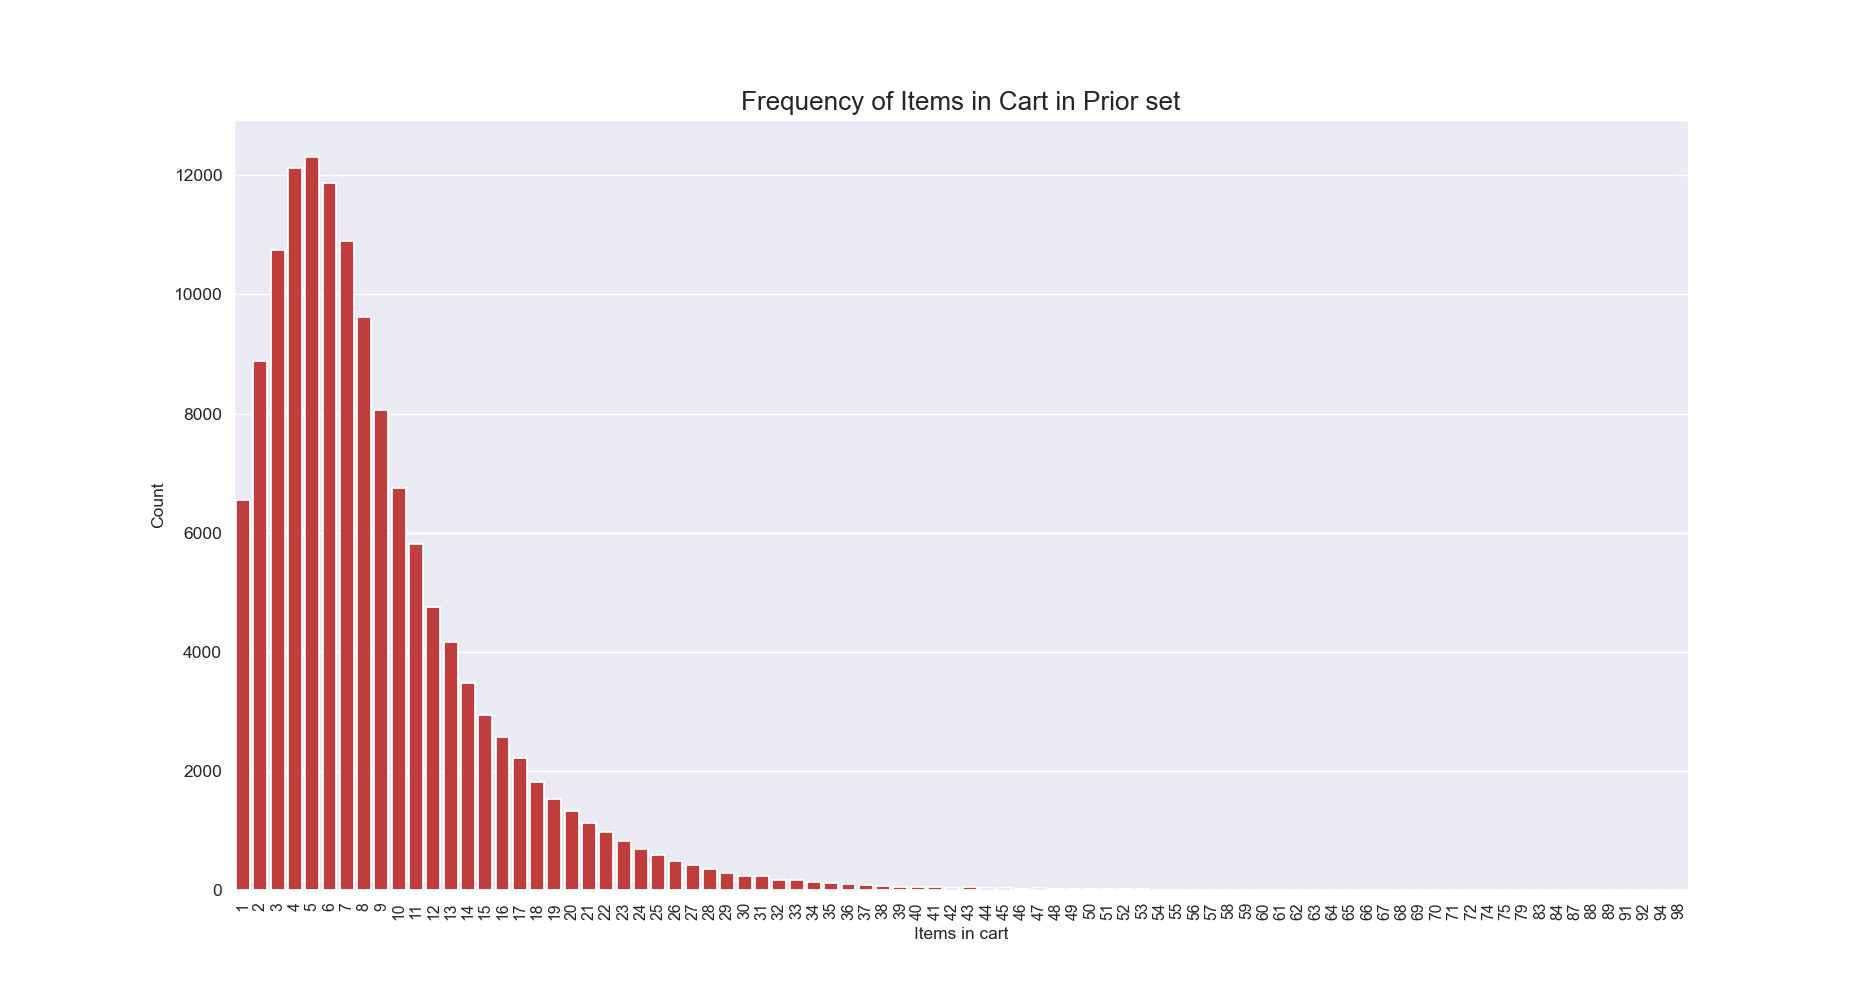

Text(0.5, 1.0, 'Frequency of Items in Cart in Prior set')

In [15]:
fig, ax = plt.subplots(figsize = (15,8))
ax = sns.barplot(x = add_to_cart_order_prior.index, y = add_to_cart_order_prior.values, color = color[3])
ax.set_xlabel('Items in cart')
ax.set_ylabel('Count')
ax.xaxis.set_tick_params(rotation=90, labelsize = 9)
ax.set_title('Frequency of Items in Cart in Prior set', size = 15)


<IPython.core.display.Javascript object>


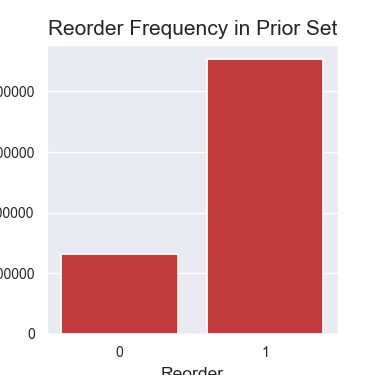

In [16]:
fig, ax = plt.subplots(figsize=(3,3))
ax = sns.barplot(x = order_products__prior_specials.reordered.value_counts().index, 
                y = order_products__prior_specials.reordered.value_counts().values, color = color[3])
ax.set_xlabel('Reorder', size = 10)
ax.set_ylabel('Count', size = 10)
ax.tick_params(axis = 'both', labelsize = 8)
ax.ticklabel_format(style='plain', axis='y')
ax.set_title('Reorder Frequency in Prior Set')
plt.show()

In [17]:
print('Percentage of reorder in prior set:',
      format(order_products__prior_specials[order_products__prior_specials.reordered == 1].shape[0]*100/order_products__prior_specials.shape[0], '.2f'))

Percentage of reorder in prior set: 77.44


In [18]:
print('       order_products_prior table')
print('      Column          Is there any garbage value?')
print('-----------------     ---------------------------')
sep='          ' 
print('         order_id',order_products__prior_specials.order_id.astype('str').str.contains('[^0-9]').any(),sep=sep)
print('       product_id',order_products__prior_specials.product_id.astype('str').str.contains('[^0-9]').any(),sep=sep)
print('add_to_cart_order',order_products__prior_specials.add_to_cart_order.astype('str').str.contains('[^0-9]').any(),sep=sep)
print('        reordered',not(order_products__prior_specials.reordered.astype('uint8').between(0,1).any()),sep=sep)

       order_products_prior table
      Column          Is there any garbage value?
-----------------     ---------------------------
         order_id          False
       product_id          False
add_to_cart_order          False
        reordered          False


# orders_distance_stores_softmax

In [19]:
orders_distance_stores_softmax.head()

,Unnamed: 0,user_id,store_id,distance,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,0,210,0,2.304404,1438665,prior,9,1,18,3.0
1,1,210,0,2.304404,2850206,prior,36,0,7,2.0
2,2,210,0,2.304404,2406913,prior,42,0,8,3.0
3,3,210,0,2.304404,1155933,prior,43,2,23,2.0
4,4,210,0,2.304404,271697,prior,56,5,17,3.0


In [20]:
print('                orders_distance_stores_softmax table')
print('         Column              Is there any garbage value?')
print('-----------------------      ---------------------------')
sep='          ' 
print('               order_id',orders_distance_stores_softmax.order_id.astype('str').str.contains('[^0-9]').any(),sep=sep)
print('                user_id',orders_distance_stores_softmax.user_id.astype('str').str.contains('[^0-9]').any(),sep=sep)
print('               eval_set',orders_distance_stores_softmax.eval_set.astype('str').str.contains('[^\b(prior|train|test)\b]').any(),sep=sep)
print('           order_number',orders_distance_stores_softmax.order_number.astype('str').str.contains('[^0-9]').any(),sep=sep)
print('              order_dow',not(orders_distance_stores_softmax.order_dow.between(0,6).any()),sep=sep)
print('      order_hour_of_day',not(orders_distance_stores_softmax.order_hour_of_day.between(0,23).any()),sep=sep)
print(' days_since_prior_order',not(orders_distance_stores_softmax.days_since_prior_order.between(0,30).any()),sep=sep)

                orders_distance_stores_softmax table
         Column              Is there any garbage value?
-----------------------      ---------------------------
               order_id          False
                user_id          False
               eval_set          False
           order_number          False
              order_dow          False
      order_hour_of_day          False
 days_since_prior_order          False


# Merging Tables.

In [21]:
# merging orders, order_products_prior and order_products_train
dist_store_df = orders_distance_stores_softmax.drop("Unnamed: 0", axis=1)
prod_prior_df = order_products__prior_specials.drop("Unnamed: 0", axis=1)
order_products = pnd.concat([prod_prior_df],ignore_index=True)
data = dist_store_df.merge(order_products,on='order_id')
data.sort_values(['user_id','order_number','add_to_cart_order'],inplace=True, axis='index',\
                 ignore_index=True)
data

,user_id,store_id,distance,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,special
0,210,5,0.367535,3264342,prior,1,0,12,NaN,33043,1,0,30
1,210,5,0.367535,3264342,prior,1,0,12,NaN,7559,2,0,0
2,210,5,0.367535,3264342,prior,1,0,12,NaN,28199,3,0,50
3,210,5,0.367535,3264342,prior,1,0,12,NaN,24799,4,0,30
4,210,5,0.367535,3264342,prior,1,0,12,NaN,36389,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172307,206105,0,3.038237,1279578,prior,98,5,20,1.0,14464,4,1,0
1172308,206105,0,3.038237,1279578,prior,98,5,20,1.0,14335,5,1,15
1172309,206105,0,3.038237,1279578,prior,98,5,20,1.0,42347,6,1,30
1172310,206105,8,0.546013,3367002,prior,99,6,7,1.0,1208,1,1,0


<IPython.core.display.Javascript object>


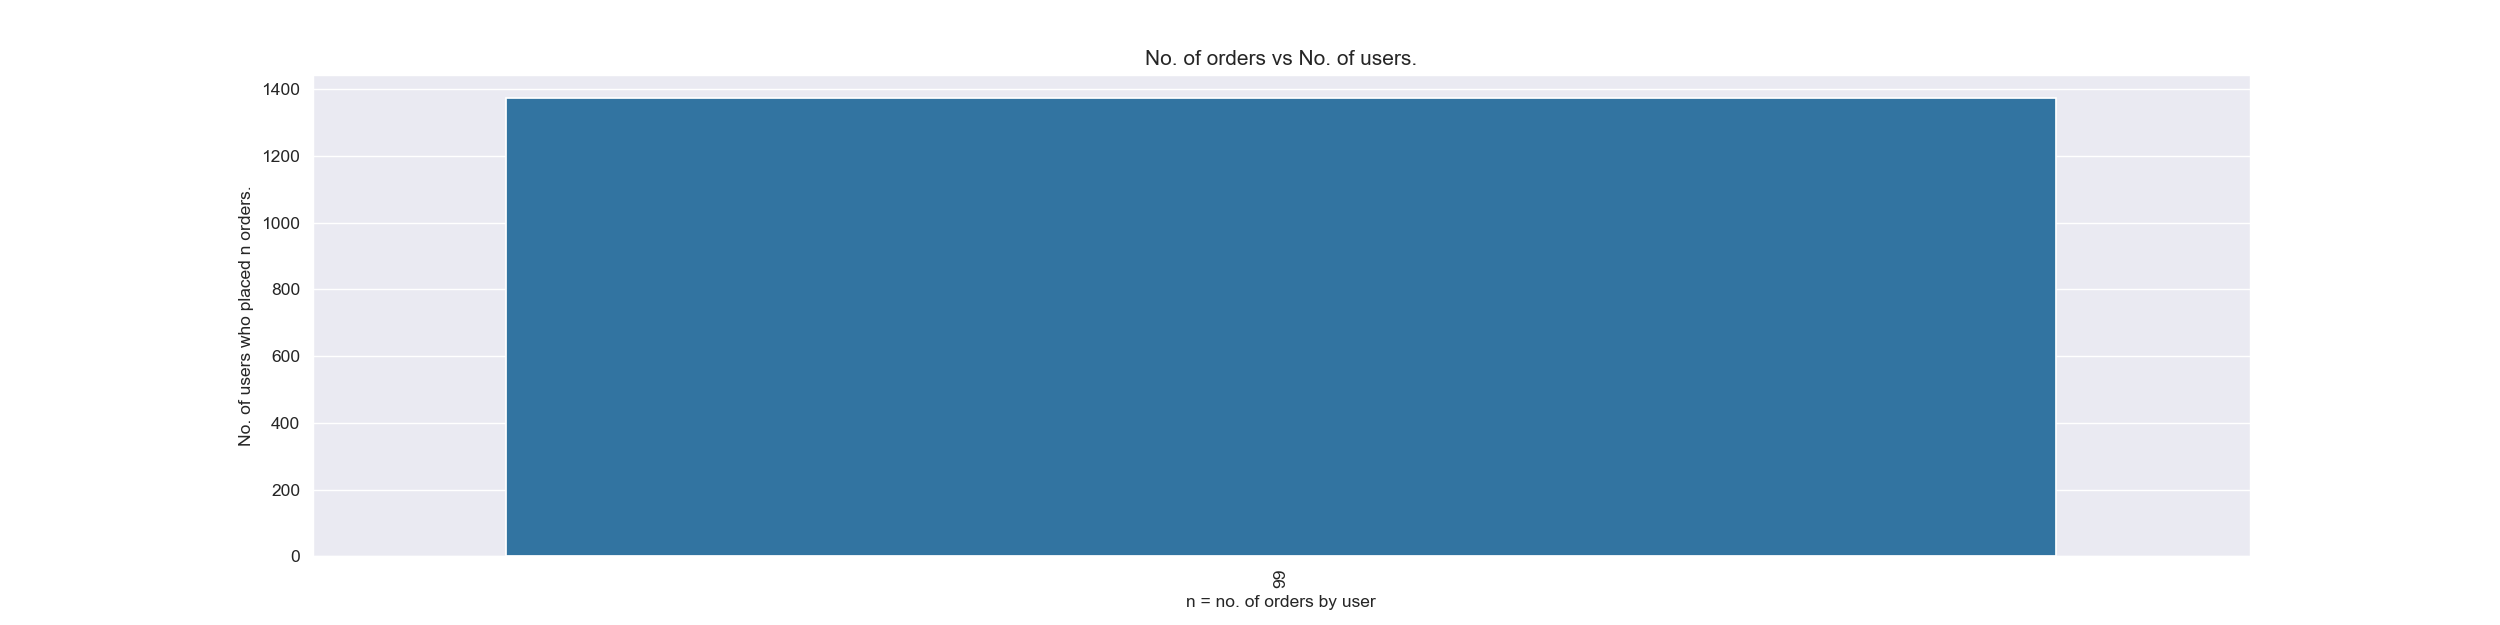

In [22]:
num_of_orders_per_user = dist_store_df.groupby('user_id').size()\
                                .rename('#orders')\
                                .sort_values()\
                                .reset_index()
fig,ax = plt.subplots(figsize=(20,5))
sns.countplot(data=num_of_orders_per_user, x='#orders',ax=ax)
plt.title('No. of orders vs No. of users.')
plt.xlabel('n = no. of orders by user')
plt.ylabel('No. of users who placed n orders.')
plt.xticks(rotation=90);

# Q. How many orders have n number of products?

<IPython.core.display.Javascript object>


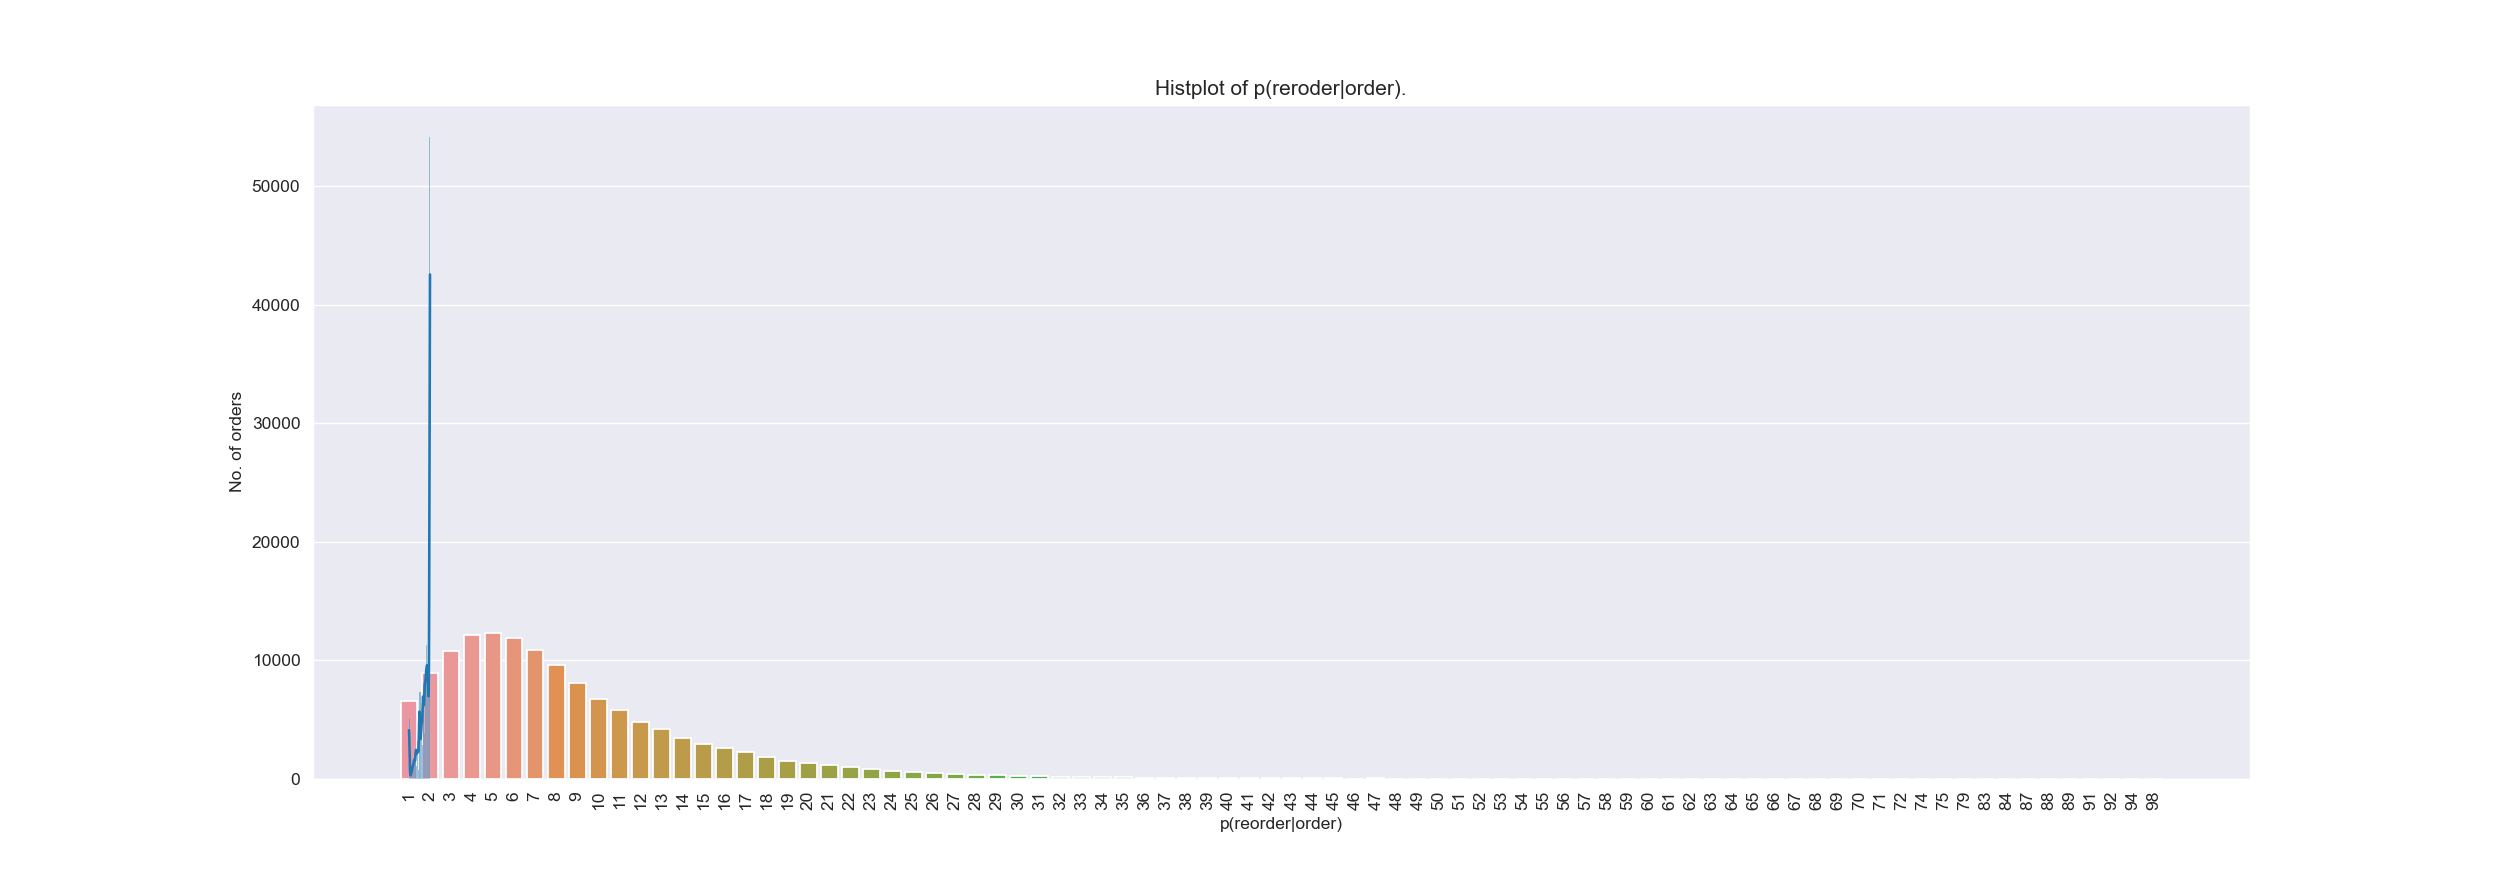

In [23]:
num_of_prods_per_order = data.groupby('order_id').size()\
                                        .rename('#products')\
                                        .sort_values()\
                                        .reset_index()
fig,ax = plt.subplots(figsize=(20,7))
sns.countplot(data=num_of_prods_per_order, x='#products',ax=ax)
plt.title('No. of products vs No. of orders.')
plt.xlabel('n = No. of ordered products in an order.')
plt.ylabel('No. of orders with n no. of products.')
plt.xticks(rotation=90);

Une commande peut comporter entre 1 et 145 produits.

Lorsque le nombre de produits dans une commande augmente de plus de 6, le nombre de commandes commence à diminuer.

Conclusion:

Les clients ont généralement tendance à acheter moins de 20 produits par commande.

La plupart des commandes ont 5-6 produits.

# Q. What was the distribution of probability of reorder in all orders?

In [24]:
order_info = data.groupby('order_id')['reordered'].agg(['sum','count','mean'])
order_info.head(3)

,sum,count,mean
order_id,,,
15,5,5,1.000000
50,3,7,0.428571
79,7,8,0.875000


In [25]:
sns.histplot(data=order_info, x='mean',kde=True,binwidth=0.05,)
plt.xlabel('p(reorder|order)')
plt.ylabel('No. of orders')
plt.title('Histplot of p(reroder|order).')


Text(0.5, 1.0, 'Histplot of p(reroder|order).')

# Q. How many products are reordered on each day of week and at each hour of day?

<IPython.core.display.Javascript object>


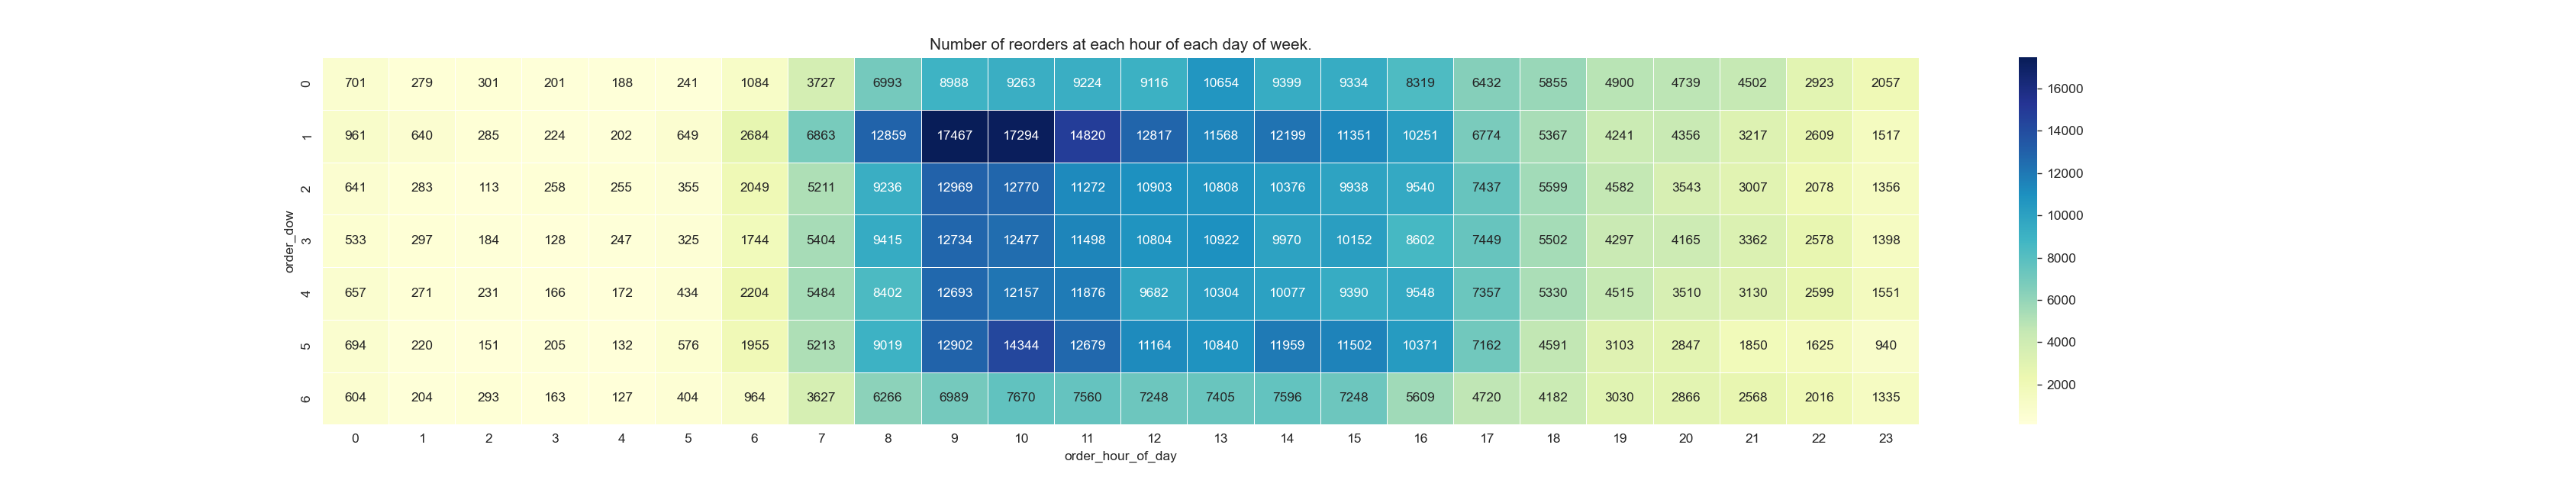

In [26]:
no_of_reorders_at_time = data.pivot_table(values='reordered',
                                          index='order_dow',
                                          columns='order_hour_of_day',
                                          aggfunc=sum)\
                                          .astype('int64')
fig, ax = plt.subplots(figsize=(27,5))
sns.heatmap(no_of_reorders_at_time,annot=True,fmt='d',linewidth=.5,cmap="YlGnBu",ax=ax)
plt.title('Number of reorders at each hour of each day of week.');

Analysis:

Les clients adorent commander à nouveau les jours 0 et 1 de la semaine entre la 8e et la 17e heure de la journée.

Après cela, le 2e créneau le plus populaire est le jour 2-6 de la semaine entre la 8e et la 17e heure de la journée.

Il y a très peu de commandes chaque jour entre la 2ème et la 5ème heure.

Conclusion:

Le créneau numéro 1 pour le réapprovisionnement des produits est le jour 0-1 de la semaine entre la 8e et la 17e heure de la journée.

# Q. How many products are sold after a gap of certain number of days in customer's order?

<IPython.core.display.Javascript object>


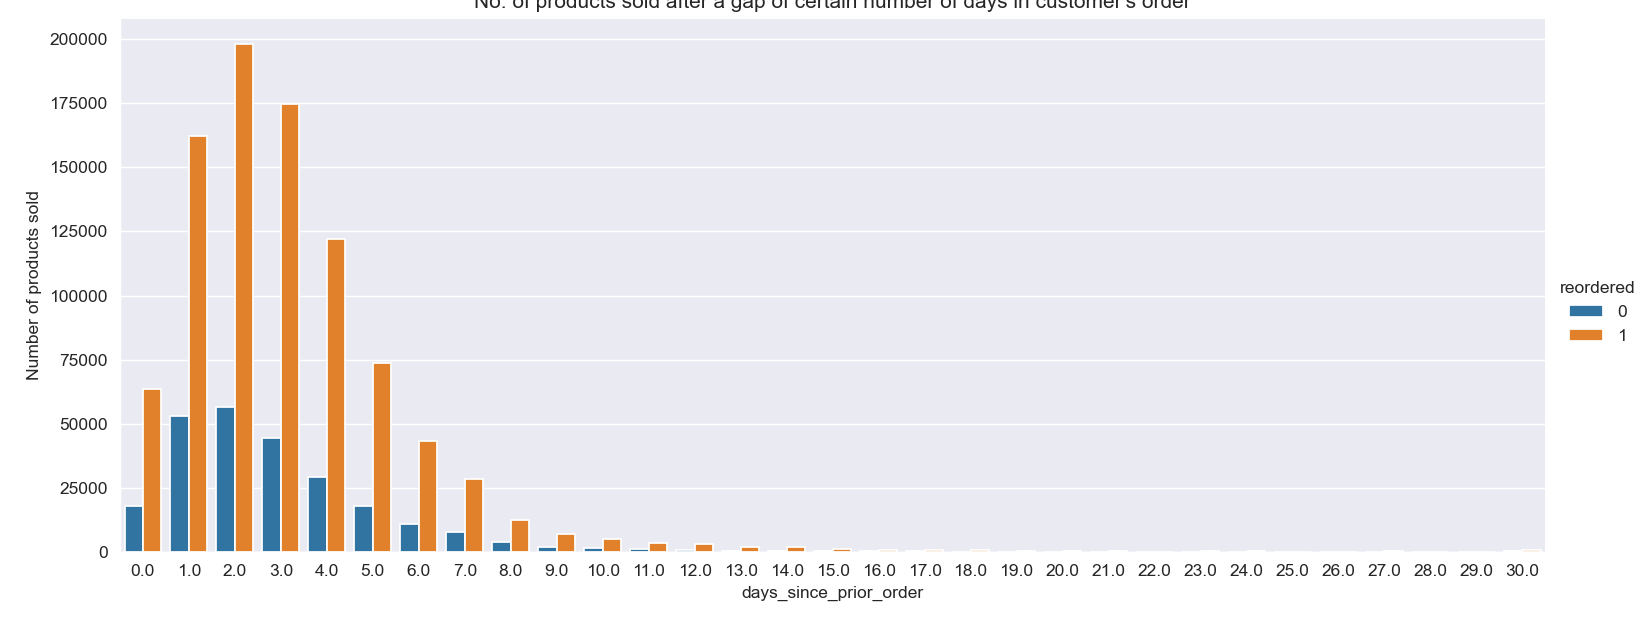

In [27]:
sns.catplot(x='days_since_prior_order',hue='reordered',data=data,kind='count',aspect=2.5)
plt.ylabel('Number of products sold')
plt.title("No. of products sold after a gap of certain number of days in customer's order");

Analysis:

Lorsque les clients reviennent le même jour, ils ont tendance à acheter beaucoup plus de produits commandés que de produits non commandés.

La plupart des clients aiment revenir chaque semaine (clients hebdomadaires).

Les clients qui reviennent chaque semaine commandent plus du double qu'ils n'achètent les nouveaux produits pour la première fois

Il y a une diminution soudaine du nombre de produits vendus pour les clients qui viennent après un intervalle de 8 à 13 jours. 
Cela signifie que certains clients aiment venir après 2 semaines (clients toutes les deux semaines).



l y a beaucoup de clients qui aiment venir sur une base mensuelle (clients mensuels) et ils achètent davantage de nouveaux produits.

Conclusion:

Les produits vendus pour les clients qui viennent après 0 à 15 jours sont pour la plupart des réapprovisionnement

Les clients qui viennent après chaque semaine commandent beaucoup.


In [28]:
order_products = order_products.merge(products, on ='product_id', how='left')
order_products = order_products.merge(aisles, on ='aisle_id', how='left')
order_products = order_products.merge(departments, on ='department_id', how='left')
order_products = order_products.merge(data, on='order_id', how='left')
order_products.shape

MemoryError: Unable to allocate 609. MiB for an array with shape (5, 15969722) and data type int64

In [ ]:
order_products.head()

# Dataset Preparation

In [29]:
product_unique_users = order_products.groupby('product_name')['user_id'].nunique().reset_index().rename(columns={'user_id':'total_users'})
product_unique_users.sort_values('total_users', ascending = False).head(10)

KeyError: 'Column not found: user_id'

In [73]:
# sorting prior_data to get a more structured data so that we can analyse well.
data.sort_values(['user_id','order_number','add_to_cart_order'],inplace=True, axis='index',\
                 ignore_index=True)
data

,user_id,store_id,distance,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,special,add_to_cart_order_mod
0,210,5,0.367535,3264342,prior,1,0,12,NaN,33043,1,0,30,1
1,210,5,0.367535,3264342,prior,1,0,12,NaN,7559,2,0,0,2
2,210,5,0.367535,3264342,prior,1,0,12,NaN,28199,3,0,50,3
3,210,5,0.367535,3264342,prior,1,0,12,NaN,24799,4,0,30,4
4,210,5,0.367535,3264342,prior,1,0,12,NaN,36389,5,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172307,206105,0,3.038237,1279578,prior,98,5,20,1.0,14464,4,1,0,4
1172308,206105,0,3.038237,1279578,prior,98,5,20,1.0,14335,5,1,15,5
1172309,206105,0,3.038237,1279578,prior,98,5,20,1.0,42347,6,1,30,6
1172310,206105,8,0.546013,3367002,prior,99,6,7,1.0,1208,1,1,0,1


In [85]:
# users and their prior order's products
users_prior_order_products = data[['user_id','product_id']]\
                            .drop_duplicates(ignore_index=True)
users_prior_order_products

,user_id,product_id
0,210,33043
1,210,7559
2,210,28199
3,210,24799
4,210,36389
...,...,...
264428,206105,33055
264429,206105,36695
264430,206105,37876
264431,206105,9561


In [86]:
# users and their prior order's products and future_order_id
users = orders_distance_stores_softmax.loc[~orders_distance_stores_softmax.eval_set.str.contains('train'),['user_id','order_id','eval_set']]
dataset = users_prior_order_products.merge(users,on='user_id',how='inner')
del users_prior_order_products
del users
dataset

        user_id  order_id eval_set
0           210   1438665    prior
1           210   2850206    prior
2           210   2406913    prior
3           210   1155933    prior
4           210    271697    prior
...         ...       ...      ...
136021   206105   1841888    prior
136022   206105   1137676    prior
136023   206105   1439511    prior
136024   206105   1783607    prior
136025   206105   1410956    prior

[136026 rows x 3 columns]


,user_id,product_id,order_id,eval_set
0,210,33043,1438665,prior
1,210,33043,2850206,prior
2,210,33043,2406913,prior
3,210,33043,1155933,prior
4,210,33043,271697,prior
...,...,...,...,...
26178862,206105,49102,1841888,prior
26178863,206105,49102,1137676,prior
26178864,206105,49102,1439511,prior
26178865,206105,49102,1783607,prior


In [30]:
def data_clean(df):
    """
      This is a data cleaning function for feature enginnering. We did 3 steps of feature engineering
      including creating label for weekend or non weekend orders; if the department is staple; if the product 
      id organic
    """
    
    print("Getting dummies...")
    df['weekend'] = 0
    df.loc[(df['order_dow'] == 5) | (df['order_dow'] == 6),'weekend'] = 1
    
    # Department staples
    print('Encoding dept staples...')
    staples = {
        'dairy eggs' : 1,
        'produce' : 1,
        'pantry' : 0,
        'meat seafood' : 1,
        'bakery' : 0,
        'personal care' : 0,
        'snacks' : 0,
        'breakfast' : 0,
        'beverages' : 0,
        'deli' : 0,
        'household' : 0,
        'international' : 0,
        'dry goods pasta' : 1,
        'frozen' : 0,
        'canned goods' : 0,
        'babies' : 0,
        'pets' : 0,
        'alcohol' : 0,
        'bulk' : 0,
        'missing' : 0,
        'other' : 0
    }
    
    print('Encoding organic products...')
    df.loc[:, 'product_is_organic'] = 0
    
    
    
    return df

parce que nous avons 3 millions de lignes, nous décidons de sous-ensemble d'abord pour réduire à la portée de l'exécution de python localement

In [31]:
df_subset = data.sample(frac=0.05, replace=False, random_state=42)

In [32]:
df_subset.shape

(58616, 13)

<IPython.core.display.Javascript object>


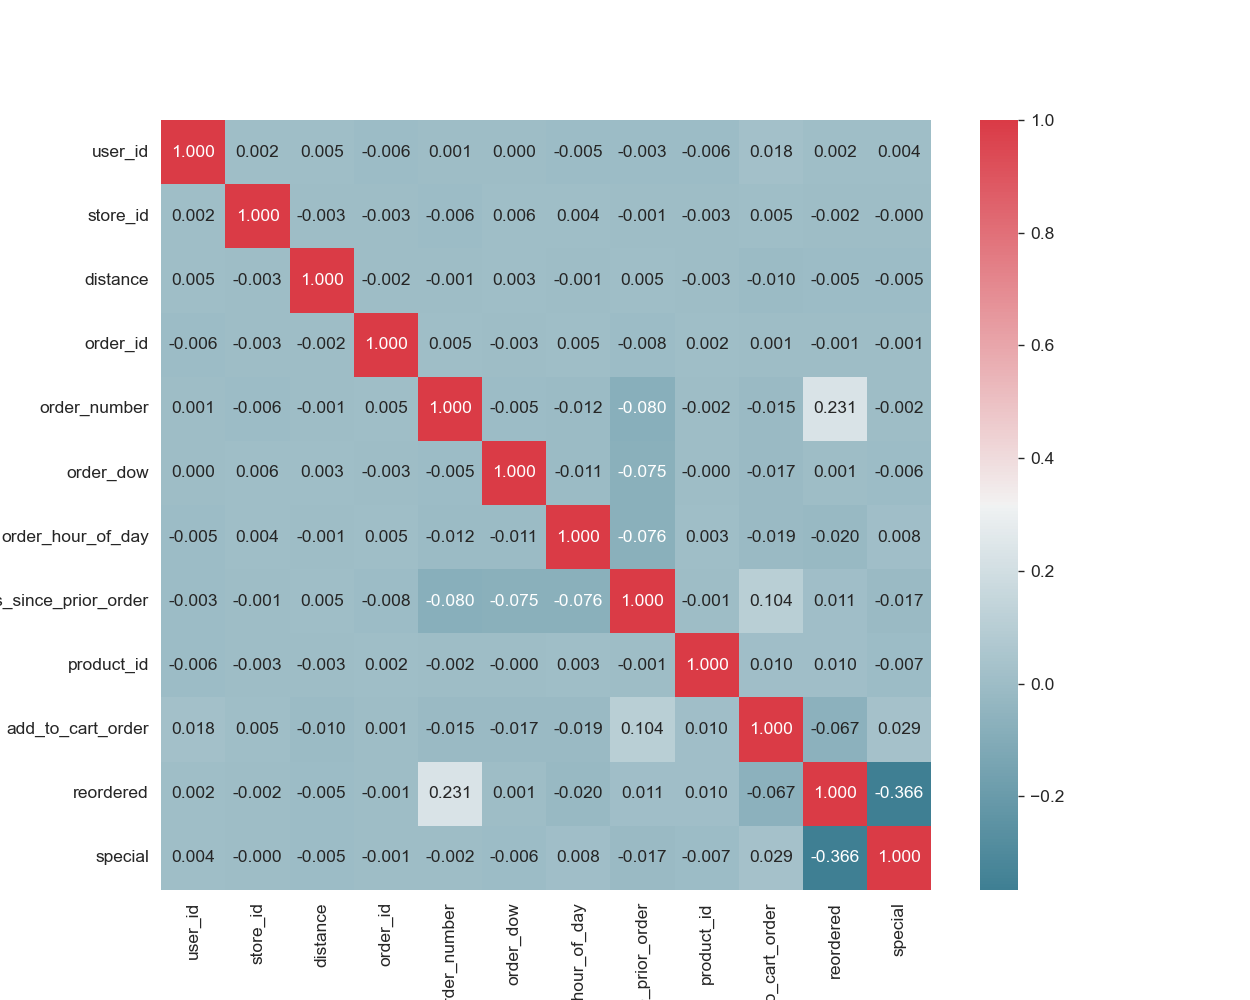

C:\Users\randr\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [33]:
import seaborn as sns
from matplotlib import pyplot as pl
f, ax = pl.subplots(figsize=(10, 8))
corr = df_subset.corr()
p=sns.heatmap(corr, annot=True,mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax,fmt=".3f")
p.get_figure().savefig('heatmap.png')

# Train-test split : Stratified shuffle split
En raison du grand nombre de lignes , nous utiliserons la stratification pour tester notre code de recherche aléatoire. Effectuez une scission stratifiée train-test de notre ensemble de données sur un sous-ensemble de données.

In [34]:
from sklearn.model_selection import StratifiedShuffleSplit

X = data_clean(df_subset.drop(['reordered', 'eval_set'], axis=1))  # full X
y = df_subset['reordered']  # full y
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=42)
sss.get_n_splits(X, y)

Getting dummies...
Encoding dept staples...
Encoding organic products...


5

In [35]:
for train_index, test_index in sss.split(X, y):
    print(train_index)

[51601 38005 15964 ... 21786 23664  6359]
[57735 20627 16794 ... 37510 20988 50297]
[27888 53015   418 ... 16578  9283 22276]
[21157 43048 48388 ... 26742 13331 27557]
[56842 35462 21207 ... 53657  9591 14738]


In [36]:
X_train = X.iloc[train_index, :]
y_train = y.iloc[train_index]
X_test = X.iloc[test_index, :]
y_test = y.iloc[test_index]

In [37]:
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

In [38]:
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')

X_train: (29308, 13)
X_test: (29308, 13)


In [42]:
def make_pipelines():
    """Create a pipeline for each of the following algorithms:
    1. Logistic Regression
    2. k-nearest neighbors (KNN) 
    3. Naive Bayes (Guassian)
    4. Support Vector Machines (SVM)
    
    
    If appropriate, apply StandardScaler before the algorithm.   
    Use default hyperparameters.
    
    Return a list of all the pipelines.
    We did not include Random Forest in the pipeline due to the volume of our data so we have to run it seperately,
    we also intend to do random search for random forest so we will do that seperately
    
    """ 
    numeric_features=X_train.columns
    
    numeric_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median'))])
    
    preprocessor = compose.ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features)])
    
    LR=Pipeline([('preprocessor', preprocessor),('LogisticRegression', LogisticRegression(random_state=42))])
    KNN=Pipeline([('preprocessor', preprocessor),('scaler', StandardScaler()),('KNeighborsClassifier', KNeighborsClassifier())])
    NB=Pipeline([('preprocessor', preprocessor),('GaussianNB', GaussianNB())])
    SVM=Pipeline([('preprocessor', preprocessor),('scaler', StandardScaler()), ('SVC', SVC(random_state=42))])
    
    

    pipelines=[LR,KNN,NB,SVM]
    return pipelines

In [43]:
pipelines = make_pipelines()

In [44]:
for pipe in pipelines:
    pipe.fit(X_train, y_train)

# classification scores to compare models

In [45]:
from sklearn.metrics import classification_report

for pipe in pipelines:
    print(pipe.steps[-1][0],'\n',classification_report(y_test, pipe.predict(X_test)))

C:\Users\randr\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\randr\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\randr\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

LogisticRegression 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      6589
           1       0.78      1.00      0.87     22719

    accuracy                           0.78     29308
   macro avg       0.39      0.50      0.44     29308
weighted avg       0.60      0.78      0.68     29308

KNeighborsClassifier 
               precision    recall  f1-score   support

           0       0.51      0.28      0.37      6589
           1       0.82      0.92      0.87     22719

    accuracy                           0.78     29308
   macro avg       0.67      0.60      0.62     29308
weighted avg       0.75      0.78      0.75     29308

GaussianNB 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      6589
           1       0.78      1.00      0.87     22719

    accuracy                           0.78     29308
   macro avg       0.39      0.50      0.44     29308
weighted avg     

C:\Users\randr\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\randr\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\randr\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

SVC 
               precision    recall  f1-score   support

           0       0.65      0.22      0.32      6589
           1       0.81      0.97      0.88     22719

    accuracy                           0.80     29308
   macro avg       0.73      0.59      0.60     29308
weighted avg       0.77      0.80      0.76     29308



# weighted F1 score will be our  metric

In [46]:
from sklearn.metrics import f1_score

def sort_models(pipelines, X_data, y_data, metric=f1_score, average='weighted'):
    scores={}
    for pipe in pipelines:
        scores[pipe.steps[-1][0]]=f1_score(y_data,pipe.predict(X_data),average=average)

    scores_sorted=dict(sorted(scores.items(), key=lambda x: x[1],reverse=True))
    
    
    return scores_sorted

In [47]:
sort_models(pipelines, X_test, y_test, metric=f1_score, average='weighted')

{'SVC': 0.755285562662711,
 'KNeighborsClassifier': 0.7536179785795405,
 'LogisticRegression': 0.6770074560686328,
 'GaussianNB': 0.6770074560686328}